In [ ]:
# Deep q-learning

In [1]:
#코랩에서에서 OpenAI의 gym을 활용하기 위해 다음을 설치해주세요.

!sudo apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay
!sudo pip install pyvirtualdisplay

#설치 후 [런타임 다시 시작]을 해줘야 합니다.

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [983 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [860 kB]
Get:13 http://archive.ubuntu.com/ubuntu jamm

In [ ]:
#한글 서체 설치 # 생략 가능
#실행하려면 다음 코드 앞의 #를 삭제한 후 실행해주세요.

#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

# 설치 후 [런타임 다시 시작]을 해줘야 합니다.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,388 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

In [ ]:
#한글깨짐 해결
#이 과정이 싫다면 건너 뛰어도 상관없습니다. 실행하려면 다음 코드 앞의 #을 삭제해주세요.

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1').unwrapped
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [4]:
!pip install pyglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.7/854.7 kB 8.4 MB/s eta 0:00:00


<ipython-input-4-a28b16fec8c8>:7: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use BICUBIC or Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing f

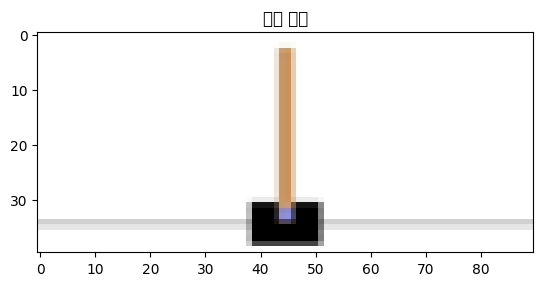

In [4]:
import pyglet
from pyvirtualdisplay import Display #코랩에서는 가상의 display를 생성해야 합니다.
display = Display(visible=False, size=(400, 300))
display.start()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('화면 예시')
plt.show()

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [8]:
num_episodes = 5

for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        action = select_action(state)
        next_state, reward, done, info, additional_info = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('종료')
env.render(mode='rgb_array')
env.close()
plt.show()

종료


In [ ]:
#12.5.2 몬테카를로 트리 검색을 적용한 틱택토 게임 구현하기

In [9]:
boarder = {'1': ' ' , '2': ' ' , '3': ' ' ,
            '4': ' ' , '5': ' ' , '6': ' ' ,
            '7': ' ' , '8': ' ' , '9': ' ' }

board_keys = []

for key in boarder:
    board_keys.append(key)

In [10]:
def visual_Board(board_num):
    print(board_num['1'] + '|' + board_num['2'] + '|' + board_num['3'])
    print('-+-+-')
    print(board_num['4'] + '|' + board_num['5'] + '|' + board_num['6'])
    print('-+-+-')
    print(board_num['7'] + '|' + board_num['8'] + '|' + board_num['9'])

In [12]:
def game():
    turn = 'X'
    count = 0

    for i in range(8):
        visual_Board(boarder)
        print("당신 차례입니다," + turn + ". 어디로 이동할까요?")
        move = input()
        if boarder[move] == ' ':
            boarder[move] = turn
            count += 1
        else:
            print("이미 채워져있습니다.\n어디로 이동할까요?")
            continue

        if count >= 5:
            if boarder['1'] == boarder['2'] == boarder['3'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['4'] == boarder['5'] == boarder['6'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['7'] == boarder['8'] == boarder['9'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['1'] == boarder['4'] == boarder['7'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['2'] == boarder['5'] == boarder['8'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['3'] == boarder['6'] == boarder['9'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['1'] == boarder['5'] == boarder['9'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['3'] == boarder['5'] == boarder['7'] != ' ':
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

        if count == 9:
            print("\n게임 종료.\n")
            print("동점입니다")


        if turn =='X':
            turn = 'Y'
        else:
            turn = 'X'

if __name__ == "__main__":
    game()

 | | 
-+-+-
 | | 
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
2
 |X| 
-+-+-
 | | 
-+-+-
 | | 
당신 차례입니다,Y. 어디로 이동할까요?
3
 |X|Y
-+-+-
 | | 
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
2
이미 채워져있습니다.
어디로 이동할까요?
 |X|Y
-+-+-
 | | 
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
0


KeyError: ignored